# Imports

In [1]:
from cohirf.experiment.spherical_clustering import generate_spherical_clusters, visualize_3d_data
from cohirf.models.kernel_kmeans import KernelKMeans
from cohirf.models.batch_cohirf import BatchCoHiRF
from cohirf.models.cohirf import ModularCoHiRF
from cohirf.models.pseudo_kernel import PseudoKernelClustering
from ml_experiments.tuners import OptunaTuner
from ml_experiments.utils import unflatten_dict, update_recursively
from sklearn.metrics import adjusted_rand_score
from sklearn.kernel_approximation import Nystroem, RBFSampler, PolynomialCountSketch
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans, HDBSCAN, DBSCAN, OPTICS
import optuna
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
from types import SimpleNamespace
import plotly.express as px
from pathlib import Path

In [2]:
def training_fn(trial, model_cls, model_kwargs, X, y):
    params = trial.params
    parsed_params = unflatten_dict(params)
    parsed_params = update_recursively(parsed_params, model_kwargs)
    model = model_cls(**parsed_params)
    labels = model.fit_predict(X)
    # if -1 in labels (for example noise data for DBSCAN) we offset it to the last cluster
    if -1 in labels:
        labels = np.where(labels == -1, np.max(labels) + 1, labels)
    return adjusted_rand_score(y, labels)

In [3]:
def train_best_model_and_show_results(model_cls, model_kwargs, study, X, y):
    best_params = study.best_params
    best_value = study.best_value
    print(f"Best parameters: {best_params}, Best Value: {best_value:.3f}")
    best_params = unflatten_dict(best_params)
    best_params = update_recursively(best_params, model_kwargs)
    best_model = model_cls(**best_params)
    labels = best_model.fit_predict(X)
    # if -1 in labels (for example noise data for DBSCAN) we offset it to the last cluster
    if -1 in labels:
        labels = np.where(labels == -1, np.max(labels) + 1, labels)
    ari = adjusted_rand_score(y, labels)
    n_clusters = len(np.unique(labels))
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
    palette = sns.color_palette()
    cmap = ListedColormap(palette.as_hex())
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap=cmap, s=2, vmin=0, vmax=10)
    ax.set_title(f"Best {model_cls.__name__}: ARI {ari:.3f}, Clusters {n_clusters}")
    plt.show()
    return best_model, labels

#  Dataset Large

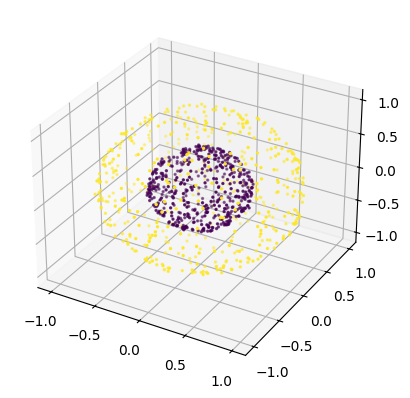

In [87]:
# dataset parameters
mean_r = [0.5, 1]  # Mean radii of the spheres
std = 0.01  # Standard deviation for the radii
seed_dataset = 42
n_samples = int(1e3)
n_samples_per_sphere = int(n_samples / 2)  # Number of samples per sphere
X, y = generate_spherical_clusters(mean_r, std, num_points_per_sphere=n_samples_per_sphere, seed=seed_dataset)
# add random features
n_random_features = int(1e4)
generator = np.random.RandomState(seed_dataset)
X_random = generator.standard_normal(size=(n_samples, n_random_features))
X = np.hstack((X, X_random))
visualize_3d_data(X[:,:3], y)

## DBSCAN

In [107]:
n_r_features = 4
random_state_model = 42000
model_cls = DBSCAN
search_space = {
    "eps": optuna.distributions.FloatDistribution(1e-1, 10),
    "min_samples": optuna.distributions.IntDistribution(5, 50),
}
model_kwargs = {
    "n_jobs": 10,
    "metric": "l1",
}
training_fn_partial = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, X=X[:, 0:(n_r_features+3)], y=y)
tuner = OptunaTuner(sampler="tpe", n_trials=100, seed=random_state_model)
study = tuner.tune(training_fn=training_fn_partial, search_space=search_space, direction="maximize")

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-06-09 18:41:51,397] A new study created in memory with name: no-name-89bf70b6-8158-469a-9a55-231936be753d


Trials:   0%|          | 0/100 [00:00<?, ?it/s]

Best parameters: {'eps': 2.331496174326169, 'min_samples': 21}, Best Value: 0.062


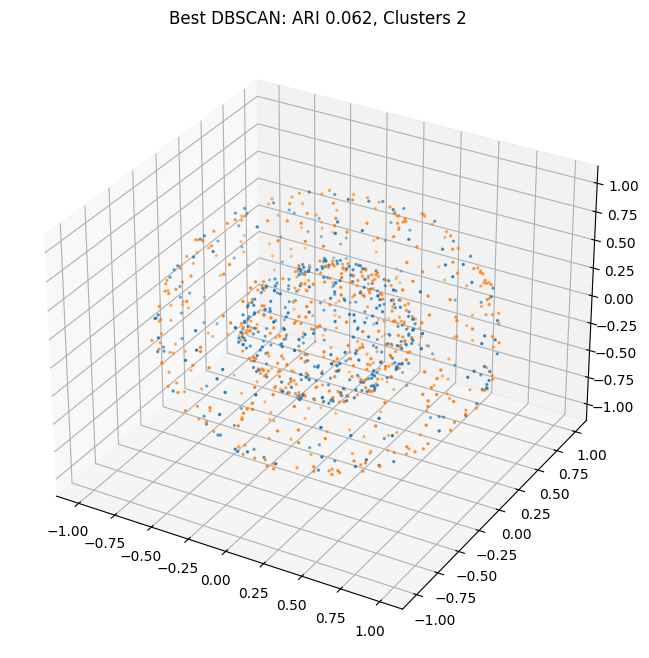

In [108]:
best_model, labels = train_best_model_and_show_results(model_cls, model_kwargs, study, X[:, 0:(n_r_features+3)], y)

## HDBSCAN

In [95]:
n_r_features = 2
random_state_model = 42000
model_cls = HDBSCAN
search_space = {
    "min_cluster_size": optuna.distributions.IntDistribution(5, 50),
    # "min_samples": optuna.distributions.IntDistribution(5, 50),
    # "cluster_selection_epsilon": optuna.distributions.FloatDistribution(1e-1, 10),
}
model_kwargs = {
    "n_jobs": 10,
}
training_fn_partial = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, X=X[:, 0:(n_r_features+3)], y=y)
tuner = OptunaTuner(sampler="tpe", n_trials=100, seed=random_state_model)
study = tuner.tune(training_fn=training_fn_partial, search_space=search_space, direction="maximize")

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-06-09 18:38:56,833] A new study created in memory with name: no-name-a16d328c-6cde-4f8c-881a-3fc9cb8372fb


Trials:   0%|          | 0/100 [00:00<?, ?it/s]

Best parameters: {'min_cluster_size': 6}, Best Value: 0.301


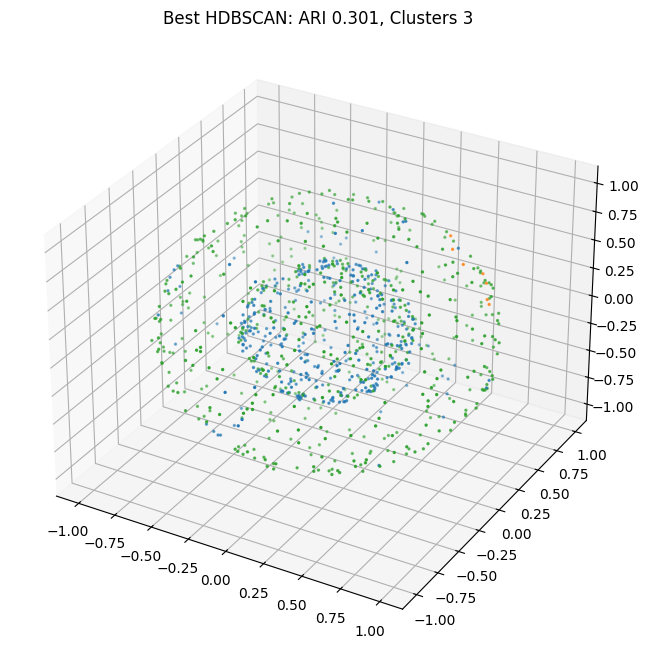

In [96]:
model, labels = train_best_model_and_show_results(model_cls, model_kwargs, study, X[:, 0 : (n_r_features + 3)], y)

Best parameters: {}, Best Value: 0.000


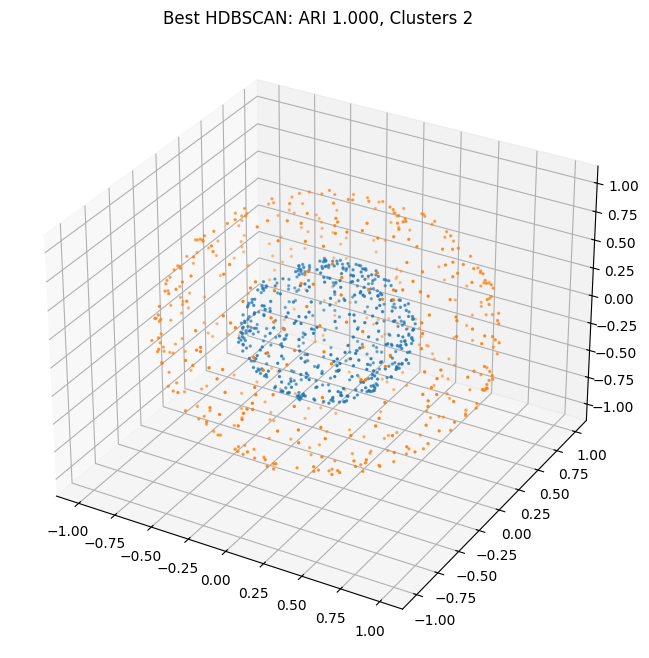

(HDBSCAN(cluster_selection_epsilon=0.1, min_cluster_size=10, n_jobs=10),
 array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1

In [83]:
model_cls = HDBSCAN
model_kwargs = dict(min_cluster_size=10, n_jobs=10, allow_single_cluster=False, cluster_selection_epsilon=0.1)
study = SimpleNamespace()
study.best_params = dict()
study.best_value = 0.0
train_best_model_and_show_results(model_cls, model_kwargs, study, X[:,0:3], y)

## CoHiRF DBSCAN

In [129]:
n_r_features = 1
random_state_model = 42000
model_cls = ModularCoHiRF
search_space = {
    "n_features": optuna.distributions.IntDistribution(1, 3 + n_r_features),
	# "repetitions": optuna.distributions.IntDistribution(1, 8),
    "base_model_kwargs": {
        "eps": optuna.distributions.FloatDistribution(1e-1, 10),
        "min_samples": optuna.distributions.IntDistribution(5, 50),
    },
}
model_kwargs = {
    "base_model": DBSCAN,
    "random_state": random_state_model,
	"repetitions": 1,
	# "n_features": 3 + n_r_features,  # 3 features from the spherical clusters + n_r_features random features
}
training_fn_partial = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, X=X[:, 0:(n_r_features+3)], y=y)
tuner = OptunaTuner(sampler="tpe", n_trials=100, seed=random_state_model)
study = tuner.tune(training_fn=training_fn_partial, search_space=search_space, direction="maximize")

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-06-09 18:48:43,251] A new study created in memory with name: no-name-d341e5c0-941c-4d4c-b44c-ba036814f2ff


Trials:   0%|          | 0/100 [00:00<?, ?it/s]

Best parameters: {'n_features': 4, 'base_model_kwargs/eps': 0.39639294133560277, 'base_model_kwargs/min_samples': 6}, Best Value: 0.471


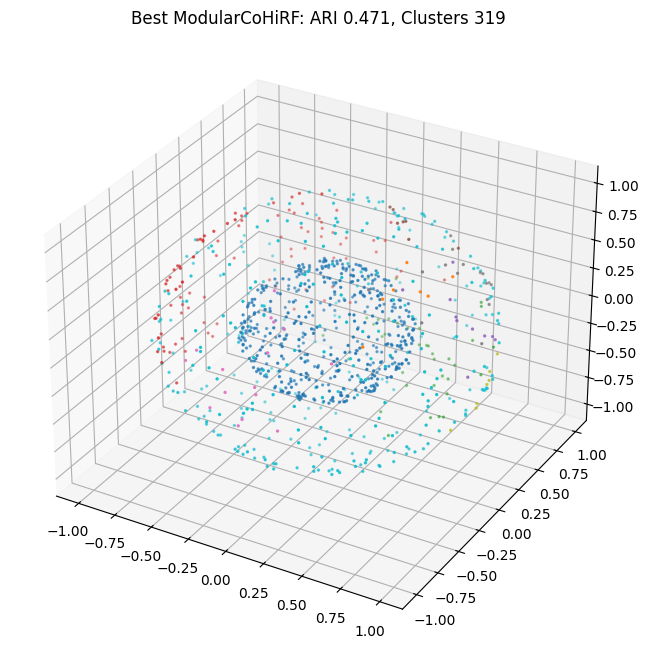

In [130]:
best_model, labels = train_best_model_and_show_results(model_cls, model_kwargs, study, X[:, 0:(n_r_features+3)], y)

Best parameters: {}, Best Value: 0.000


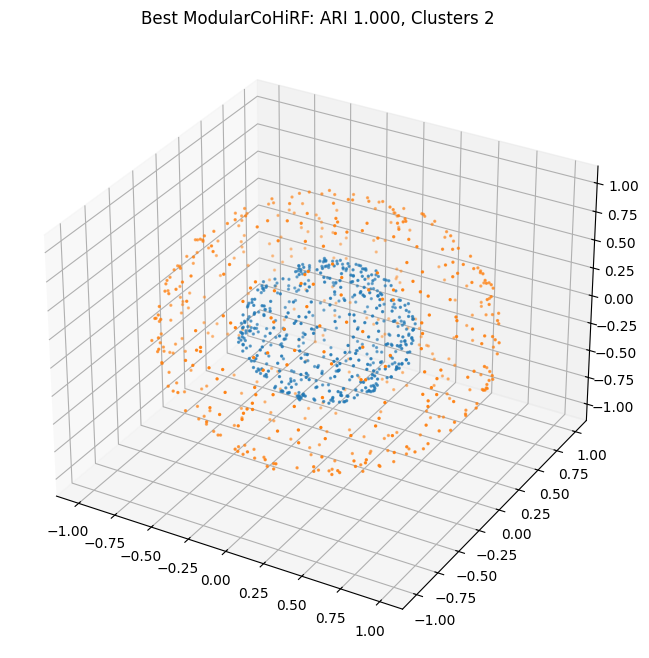

In [124]:
model_cls = ModularCoHiRF
model_kwargs = dict(
	base_model=DBSCAN,
	base_model_kwargs=dict(
		eps=0.3,
		min_samples=8,
	),
	random_state=random_state_model,
	repetitions=1,
	n_features=3,
	hierarchy_strategy='labels'
)
study = SimpleNamespace()
study.best_params = dict()
study.best_value = 0  # Dummy value for demonstration purposes
best_model, labels = train_best_model_and_show_results(model_cls, model_kwargs, study, X[:, 0:3], y)

## Batch CoHiRF DBSCAN

In [6]:
random_state_model = 42000
batch_size = int(1e3)
model_cls = BatchCoHiRF
search_space = {
    "cohirf_kwargs": {
        "base_model_kwargs": {
            "eps": optuna.distributions.FloatDistribution(1e-1, 10),
            "min_samples": optuna.distributions.IntDistribution(5, 50),
        },
        "n_features": optuna.distributions.IntDistribution(1, 3),
    },
}
model_kwargs = {
    "cohirf_model": ModularCoHiRF,
    "cohirf_kwargs": dict(base_model=DBSCAN, random_state=random_state_model, repetitions=1, max_iter=1),
    "batch_size": batch_size,
    "n_jobs": 10,
	"hierarchy_strategy":'labels'
}

training_fn_partial = partial(
    training_fn, model_cls=model_cls, model_kwargs=model_kwargs, X=X, y=y
)
tuner = OptunaTuner(sampler="tpe", n_trials=100, seed=random_state_model)
study = tuner.tune(training_fn=training_fn_partial, search_space=search_space, direction="maximize")

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-06-09 13:20:53,513] A new study created in memory with name: no-name-171ca2d0-f961-4b75-8ae2-8d0ff1aa2b12


Trials:   0%|          | 0/100 [00:00<?, ?it/s]

Best parameters: {'cohirf_kwargs/base_model_kwargs/eps': 0.40270122597233515, 'cohirf_kwargs/base_model_kwargs/min_samples': 34, 'cohirf_kwargs/n_features': 3}, Best Value: 1.000
Starting epoch 0
Updating labels
Starting epoch 1
Updating labels
Starting epoch 2
Updating labels


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


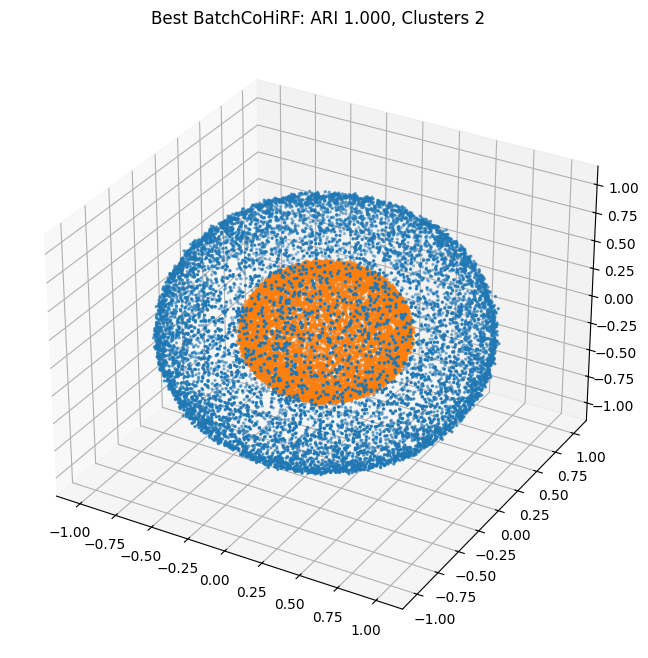

In [7]:
model_kwargs["verbose"] = True
best_model, labels = train_best_model_and_show_results(model_cls, model_kwargs, study, X, y)

Best parameters: {}, Best Value: 0.000


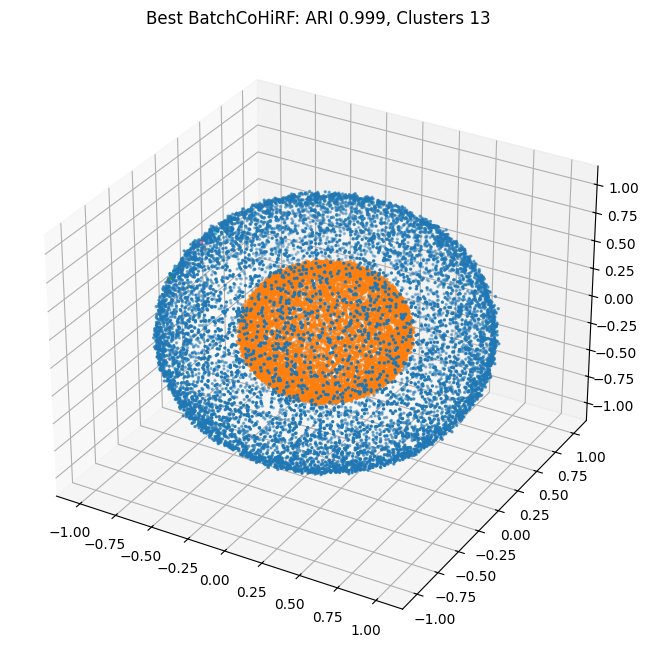

In [34]:
model_cls = BatchCoHiRF
model_kwargs = dict(
    cohirf_model=ModularCoHiRF,
    cohirf_kwargs=dict(
        base_model=DBSCAN,
        base_model_kwargs=dict(
            eps=0.41,
            min_samples=24,
        ),
        random_state=random_state_model,
        repetitions=1,
        max_iter=1,
    ),
    batch_size=batch_size,
    n_jobs=1,
    hierarchy_strategy='labels',
)
study = SimpleNamespace()
study.best_params = dict()
study.best_value = 0  # Dummy value for demonstration purposes
best_model, labels = train_best_model_and_show_results(model_cls, model_kwargs, study, X, y)

## Batch CoHiRF DBSCAN first batch

In [11]:
n_samples/batch_size

20.0

In [30]:
random_state_model = 42000
batch_size = int(1e3)
model_cls = BatchCoHiRF
search_space = {
    "cohirf_kwargs": {
        "base_model_kwargs": {
            "eps": optuna.distributions.FloatDistribution(1e-1, 10),
            "min_samples": optuna.distributions.IntDistribution(5, 50),
        },
        "n_features": optuna.distributions.IntDistribution(1, 3),
    },
}
model_kwargs = {
    "cohirf_model": ModularCoHiRF,
    "cohirf_kwargs": dict(base_model=DBSCAN, random_state=random_state_model, repetitions=1, max_iter=1),
    "batch_size": batch_size,
    "n_jobs": 10,
}
X_batch = X[-9*batch_size:]
y_batch = y[-9*batch_size:]
training_fn_partial = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, X=X_batch, y=y_batch)
tuner = OptunaTuner(sampler="tpe", n_trials=100, seed=random_state_model)
study = tuner.tune(training_fn=training_fn_partial, search_space=search_space, direction="maximize")

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-06-09 13:26:52,525] A new study created in memory with name: no-name-a7590ecc-7f15-44fc-bb69-57eff6b5196e


Trials:   0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_cohirf_kwargs/base_model_kwargs/eps,params_cohirf_kwargs/base_model_kwargs/min_samples,params_cohirf_kwargs/n_features,user_attrs_result,state
0,0,0.000000,2025-06-09 13:26:52.539035,2025-06-09 13:26:52.646106,0 days 00:00:00.107071,1.261798,14,2,0.000000,COMPLETE
1,1,0.056774,2025-06-09 13:26:52.647080,2025-06-09 13:26:52.976577,0 days 00:00:00.329497,0.309475,39,3,0.056774,COMPLETE
2,2,0.000000,2025-06-09 13:26:52.977316,2025-06-09 13:26:53.070115,0 days 00:00:00.092799,1.006350,34,2,0.000000,COMPLETE
3,3,0.000000,2025-06-09 13:26:53.070287,2025-06-09 13:26:53.175798,0 days 00:00:00.105511,1.409345,10,3,0.000000,COMPLETE
4,4,0.000000,2025-06-09 13:26:53.176594,2025-06-09 13:26:53.247727,0 days 00:00:00.071133,5.019610,10,1,0.000000,COMPLETE
...,...,...,...,...,...,...,...,...,...,...
95,95,0.039420,2025-06-09 13:27:09.326111,2025-06-09 13:27:09.667262,0 days 00:00:00.341151,0.217727,24,3,0.039420,COMPLETE
96,96,0.000000,2025-06-09 13:27:09.668061,2025-06-09 13:27:09.771364,0 days 00:00:00.103303,1.425823,15,3,0.000000,COMPLETE
97,97,0.052424,2025-06-09 13:27:09.772173,2025-06-09 13:27:10.036850,0 days 00:00:00.264677,0.185652,16,3,0.052424,COMPLETE
98,98,0.000000,2025-06-09 13:27:10.037628,2025-06-09 13:27:10.129042,0 days 00:00:00.091414,2.317039,27,3,0.000000,COMPLETE


Best parameters: {}, Best Value: 0.000
Starting epoch 0
Updating labels
Starting epoch 1
Updating labels


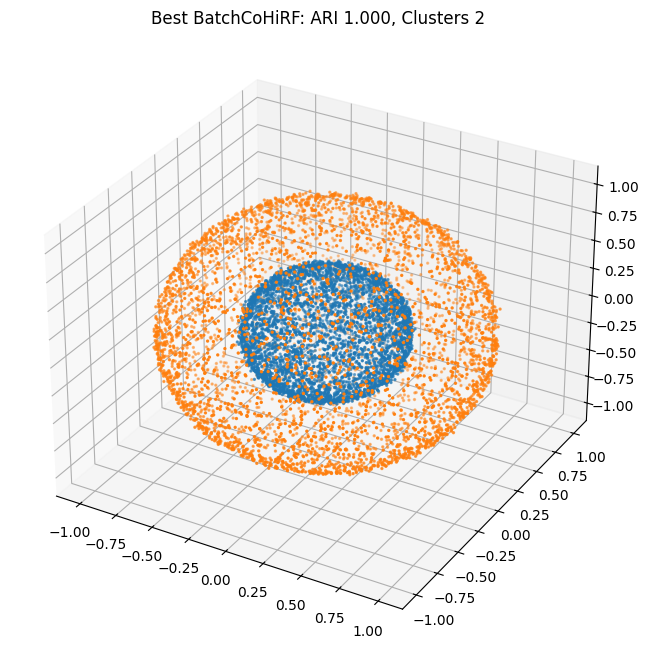

In [35]:
model_kwargs["verbose"] = True
best_model, labels = train_best_model_and_show_results(model_cls, model_kwargs, study, X_batch, y_batch)